In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice
from functions_geom_DIB import geom_DIB_on_alternatives

In [2]:
# Load data
data = pd.read_csv('../data/optima.dat', sep='\t')

# Remove missing values, i.e. choice = -1
data = data[data['Choice'] != -1]

In [3]:
# display every column of the dataframe
pd.set_option('display.max_columns', None)
data

ID  DestAct  NbTransf  TimePT  WalkingTimePT  WaitingTimePT  \
0     10350017        2         4      85             23             10   
2     10350025       11         2      82             33              5   
3     10350075        1         3     107             21             31   
4     10350085        1         5     190            116             18   
5     10350086        1         4     116             38             29   
...        ...      ...       ...     ...            ...            ...   
2259  96040531        1         4     148             28             69   
2261  96040537        8         0     139            116              0   
2262  96040537        8         0      71             57              0   
2263  96040538       11         2     118             70             10   
2264  96040538        1         3     140             53             23   

      CostPT  CostCar  TimeCar  NbHousehold  NbChild  NbCar  NbMoto  NbBicy  \
0       12.4     3.17       32            2        0      1       0       3   
2        3.0     0.45        6           -1       -1     -1      -1      -1   
3       24.0     2.36       23            2        0      1       0       0   
4       10.8     1.16       14            3        0      2       0       3   
5        9.6     1.89       20            3        0      2       0       3   
...      ...      ...      ...          ...      ...    ...     ...     ...   
2259    10.4     3.92       40            5        2      1       1       4   
2261    14.4     3.18       43            5        0      2       1       1   
2262     6.0     0.94       12            5        0      2       1       1   
2263    11.4     1.77       24            5        0      2       1       1   
2264    12.6     2.23       28            5        0      2       1       1   

      NbBicyChild  NbComp  NbTV  Internet  NewsPaperSubs  NbCellPhones  \
0               0       2     1         1              2             2   
2              -1      -1    -1        -1             -1            -1   
3               0       1     2         1              1             2   
4               0       1     2         1              2             2   
5               0       1     2         1              2             3   
...           ...     ...   ...       ...            ...           ...   
2259            2       1     1         1              1             2   
2261            0       2     1         1              2             5   
2262            0       2     1         1              2             5   
2263            0       2     1         1              2             5   
2264            0       2     1         1              2             5   

      NbSmartPhone  HouseType  OwnHouse  NbRoomsHouse  YearsInHouse  Income  \
0                2          1         2           5.0             1       4   
2               -1         -1        -1          -1.0            -1      -1   
3                0          1         1           5.0            29       2   
4                0          1         1           4.0            22       4   
5                0          1         1           4.0            22       4   
...            ...        ...       ...           ...           ...     ...   
2259             0          1         2           7.0            16       2   
2261             0          1         1           7.0            23       4   
2262             0          1         1           7.0            23       4   
2263             0          1         1           7.0            23       4   
2264             0          1         1           7.0            23       4   

      Gender  BirthYear  Mothertongue  FamilSitu  OccupStat  SocioProfCat  \
0          1       1983             2          2          3             3   
2         -1         -1            -1         -1         -1            -1   
3          2       1947             2          2          2             4   
4          1    

In [4]:
data_used = data[['ID', 'TimePT', 'WalkingTimePT', 'WaitingTimePT', 'MarginalCostPT', 'TimeCar',
                   'CostCarCHF', 'ReportedDuration', 'Choice']]

In [5]:
data_used

ID  TimePT  WalkingTimePT  WaitingTimePT  MarginalCostPT  TimeCar  \
0     10350017      85             23             10             0.0       32   
2     10350025      82             33              5             3.0        6   
3     10350075     107             21             31            24.0       23   
4     10350085     190            116             18            10.8       14   
5     10350086     116             38             29             9.6       20   
...        ...     ...            ...            ...             ...      ...   
2259  96040531     148             28             69            10.4       40   
2261  96040537     139            116              0            14.4       43   
2262  96040537      71             57              0             6.0       12   
2263  96040538     118             70             10            11.4       24   
2264  96040538     140             53             23            12.6       28   

      CostCarCHF  ReportedDuration  Choice  
0           4.54               255       1  
2           0.64                20       0  
3           3.38                30       1  
4           1.66                20       1  
5           2.71                30       1  
...          ...               ...     ...  
2259        5.62                35       1  
2261        4.56                70       1  
2262        1.35                20       1  
2263        2.54                30       1  
2264        3.20                40       1  

[1906 rows x 9 columns]

In [6]:
# beta_names = ["ASC_private", "ASC_soft", "BETA_Time", "BETA_Cost", "lambda_PT_private"]


# Define log-likelihood function
def log_likelihood_optima_NLM(beta, data):
    # Define utility functions
    data['U_PT'] = beta[2] * (data['TimePT'] + data['WalkingTimePT'] + data['WaitingTimePT']) + \
                    beta[3] * data['MarginalCostPT']
    data['U_private'] = beta[0] + beta[2] * data['TimeCar'] + beta[3] * data['CostCarCHF']
    data['U_soft'] = beta[1] + beta[2] * data['ReportedDuration']
    
    # Calculate logsum for nests with > 1 alt
    data['logsum_PT_private'] = np.log(np.exp(data['U_PT'] / beta[4]) + np.exp(data['U_private'] / beta[4]))
    
    # Nest probabilities
    data['P_nest_PT_private'] = np.exp(beta[4] * data['logsum_PT_private']) / \
                               (np.exp(beta[4] * data['logsum_PT_private']) + np.exp(data['U_soft']))
    data['P_nest_soft'] = 1 - data['P_nest_PT_private']
    
    # Within nest probabilities for nests with > 1 alt
    data['P_PT_in_PT_private'] = (np.exp(data['U_PT'] / beta[4])) / \
                                  (np.exp(data['U_PT'] / beta[4]) + np.exp(data['U_private'] / beta[4]))
    data['P_private_in_PT_private'] = 1 - data['P_PT_in_PT_private']
    
    # Full probabilities
    data['P_PT_1'] = data['P_nest_PT_private'] * data['P_PT_in_PT_private']
    data['P_private_2'] = data['P_nest_PT_private'] * data['P_private_in_PT_private']
    data['P_soft_3'] = data['P_nest_soft']

    # Calculate probability for chosen alternative for each row
    data['P'] = (data['Choice'] == 0) * data['P_PT_1'] + \
                (data['Choice'] == 1) * data['P_private_2'] + \
                (data['Choice'] == 2) * data['P_soft_3']
    
    # Calculate log-likelihood
    LL = data.groupby('ID')['P'].prod().apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood


In [7]:
# Define model parameters
beta = np.array([0, 0, 0, 0, 1])
beta_names = ["ASC_private", "ASC_soft", "BETA_Time", "BETA_Cost", "lambda_PT_soft"]

# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data_used, beta, beta_names, log_likelihood_optima_NLM)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14337/2576143386.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_PT'] = beta[2] * (data['TimePT'] + data['WalkingTimePT'] + data['WaitingTimePT']) + \
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14337/2576143386.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_private'] = beta[0] + beta[2] * data['TimeCar'] + beta[3] * data['CostCarCHF']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14337/2576143386

Optimization Results:
        Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0     ASC_private -4.663073              0.807102    -5.777554  8.836385e-09
1        ASC_soft -9.292362              1.186813    -7.829674  7.993606e-15
2       BETA_Time  0.005494              0.001370     4.011702  6.261747e-05
3       BETA_Cost  0.736106              0.098359     7.483857  1.096900e-13
4  lambda_PT_soft -8.702496              1.268028    -6.863014  9.093393e-12
AIC: 2658.0997611647745
BIC: 2685.8635715858454
Log-likelihood: -1324.0498805823872


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14337/2576143386.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['P_PT_in_PT_private'] = (np.exp(data['U_PT'] / beta[4])) / \
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14337/2576143386.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['P_private_in_PT_private'] = 1 - data['P_PT_in_PT_private']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14337/2576143386.py:26: SettingWithCopyWarning: 
A value is tryi

In [8]:
df_input = data[['TimePT', 'MarginalCostPT', 'TimeCar', 'CostCarCHF', 'ReportedDuration']]
# Calculate frequencies and probabilities
vector_counts = df_input.value_counts().reset_index(name='Frequency')
vector_counts['Probability'] = vector_counts['Frequency'] / len(df_input)

# Creating a tuple of attributes to facilitate mapping
vector_counts['tuple'] = vector_counts[['TimePT', 'MarginalCostPT', 'TimeCar', 'CostCarCHF',
                                         'ReportedDuration']].apply(tuple, axis=1)
probability_map = vector_counts.set_index('tuple')['Probability'].to_dict()

# Assign the probability to each row based on its tuple of attributes
df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14337/1679802737.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


In [9]:
# Computation of p(x,y)
p_x = df_input['Probability'].values

p_y_given_x = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [10]:
def simulate_choice_optima(row):
    """
    Function to simulate a choice based on cumulative probabilities.

    Parameters:
    - row: pandas Series or DataFrame row containing probabilities for each choice

    Returns:
    - The simulated choice (an integer between 1 and the number of choices)
    """
    # Generate a random number between 0 and 1
    random_number = np.random.rand()
    
    # Calculate cumulative probabilities
    probabilities = row[['P_PT_1', 'P_private_2', 'P_soft_3']]
    cumulative_probs = probabilities.cumsum()
    
    # Determine simulated choice based on random number
    for i, cumulative_prob in enumerate(cumulative_probs):
        if random_number <= cumulative_prob:
            return i+1

In [11]:
np.random.seed(123)
data_used['simulated_choice'] = data_used.apply(simulate_choice_optima, axis=1)
data_used

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14337/2856924636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['simulated_choice'] = data_used.apply(simulate_choice_optima, axis=1)


ID  TimePT  WalkingTimePT  WaitingTimePT  MarginalCostPT  TimeCar  \
0     10350017      85             23             10             0.0       32   
2     10350025      82             33              5             3.0        6   
3     10350075     107             21             31            24.0       23   
4     10350085     190            116             18            10.8       14   
5     10350086     116             38             29             9.6       20   
...        ...     ...            ...            ...             ...      ...   
2259  96040531     148             28             69            10.4       40   
2261  96040537     139            116              0            14.4       43   
2262  96040537      71             57              0             6.0       12   
2263  96040538     118             70             10            11.4       24   
2264  96040538     140             53             23            12.6       28   

      CostCarCHF  ReportedDuration  Choice       U_PT  U_private    U_soft  \
0           4.54               255       1   0.648331  -1.145335 -7.891307   
2           0.64                20       0   2.867637  -4.158999 -9.182475   
3           3.38                30       1  18.540134  -2.048666 -9.127532   
4           1.66                20       1   9.730105  -3.364217 -9.182475   
5           2.71                30       1   8.072077  -2.558340 -9.127532   
...          ...               ...     ...        ...        ...       ...   
2259        5.62                35       1   9.001610  -0.306386 -9.100060   
2261        4.56                70       1  12.000976  -1.070175 -8.907758   
2262        1.35                20       1   5.119908  -3.603398 -9.182475   
2263        2.54                30       1   9.479482  -2.661501 -9.127532   
2264        3.20                40       1  10.461707  -2.153694 -9.072588   

      logsum_PT_private  P_nest_PT_private  P_nest_soft  P_PT_in_PT_private  \
0              0.727003           0.827007     0.172993            0.448654   
2              0.846713           0.859840     0.140160            0.308439   
3              0.325133           0.998164     0.001836            0.085814   
4              0.587145           0.983256     0.016744            0.181731   
5              0.552316           0.986888     0.013112            0.227666   
...                 ...                ...          ...                 ...   
2259           0.330227           0.998027     0.001973            0.255483   
2261           0.324022           0.997735     0.002265            0.182127   
2262           0.726684           0.945757     0.054243            0.268472   
2263           0.527218           0.989433     0.010567            0.198592   
2264           0.458273           0.993846     0.006154            0.190059   

      P_private_in_PT_private    P_PT_1  P_private_2  P_soft_3         P  \
0                    0.551346  0.371040     0.455967  0.172993  0.455967   
2                    0.691561  0.265208     0.594632  0.140160  0.265208   
3                    0.914186  0.085657     0.912507  0.001836  0.912507   
4                    0.818269  0.178688     0.804568  0.016744  0.804568   
5                    0.772334  0.224681     0.762207  0.013112  0.762207   
...                       ...       ...          ...       ...       ...   
2259                 0.744517  0.254979     0.743048  0.001973  0.743048   
2261                 0.817873  0.181715     0.816020  0.002265  0.816020   
2262                 0.731528  0.253909     0.691848  0.054243  0.691848   
2263                 0.801408  0.196494     0.792939  0.010567  0.792939   
2264                 0.809941  0.188889     0.804957  0.006154  0.804957   

      simulated_choice  
0                    2  
2                    2  
3                    2  
4                    2  
5                    2  
...                ...  
2259                 2  
2261                 2  
2262           

Iteration: 1 out of 5000
Objective function value: 1.0985322561962754
Iteration: 2 out of 5000
Objective function value: 0.7945398305073719
Iteration: 3 out of 5000
Objective function value: 0.59918609970886
Iteration: 4 out of 5000
Objective function value: 0.4844786363479665
Iteration: 5 out of 5000
Objective function value: 0.4090347865069352
Iteration: 6 out of 5000
Objective function value: 0.35540199322338406
Iteration: 7 out of 5000
Objective function value: 0.31515775087830983
Iteration: 8 out of 5000
Objective function value: 0.28374694948807716
Iteration: 9 out of 5000
Objective function value: 0.2584866997722449
Iteration: 10 out of 5000
Objective function value: 0.23769071792379737
Iteration: 11 out of 5000
Objective function value: 0.22024378788797896
Iteration: 12 out of 5000
Objective function value: 0.2053776120451874
Iteration: 13 out of 5000
Objective function value: 0.1925448631958784
Iteration: 14 out of 5000
Objective function value: 0.18134457769628753
Iteration: 

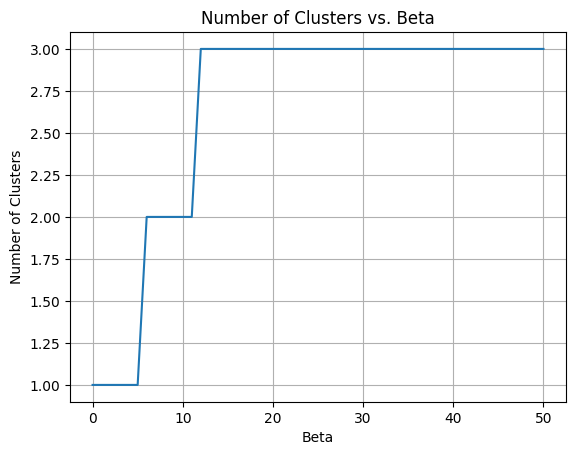

In [12]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [19]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=30, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Objective function value: 1.0930984213647235
Iteration: 2 out of 5000
Objective function value: -0.8406946783823825
Iteration: 3 out of 5000
Objective function value: -0.908589152165004
Iteration: 4 out of 5000
Objective function value: -1.0402988118836798
Iteration: 5 out of 5000
Objective function value: -1.0995874727818058
Iteration: 6 out of 5000
Objective function value: -1.1075192114811152
Iteration: 7 out of 5000
Objective function value: -1.1102126762995526
Iteration: 8 out of 5000
Objective function value: -1.111297958547467
Iteration: 9 out of 5000
Objective function value: -1.1115042694014479
Iteration: 10 out of 5000
Objective function value: -1.1115984687038312
Iteration: 11 out of 5000
Objective function value: -1.111686290585407
Iteration: 12 out of 5000
Objective function value: -1.1117112953517354


In [20]:
import re

# Define a function to extract the number from the column name
def extract_number(column_name):
    match = re.search(r'\d+', column_name)  # Search for one or more digits in the column name
    if match:
        return int(match.group())  # Return the first occurrence of digits as an integer
    else:
        return None  # Return None if no digits are found

In [21]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data_used['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data_used.groupby(['cluster', 'Choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data_used['max_proba'] = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].idxmax(axis=1).apply(extract_number)
cluster_counts2 = data_used.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data_used.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 3

 cluster
2    997
0    811
1     98
Name: count, dtype: int64

 Choice     0    1    2
cluster               
0        255  453  103
1         81   16    1
2        200  787   10

 max_proba   1    2  3
cluster              
0          14  791  6
1          98    0  0
2           0  997  0

 simulated_choice    1    2    3
cluster                        
0                 241  463  107
1                  67   30    1
2                 210  779    8


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14337/2352194042.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_14337/2352194042.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['max_proba'] = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].idxmax(axis=1).apply(extract_number)
